In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Définition du réseau
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialisation
model = SimpleNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2) # weight decay equivaut à une régularisation L2


In [104]:
# Génération de données
from sklearn.datasets import make_moons
import numpy as np

def generate_data(n_samples=500):
    X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=42)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train, y_train = generate_data()
X_test, y_test = generate_data(n_samples=200)

y_train = y_train.float()
y_test = y_test.float()

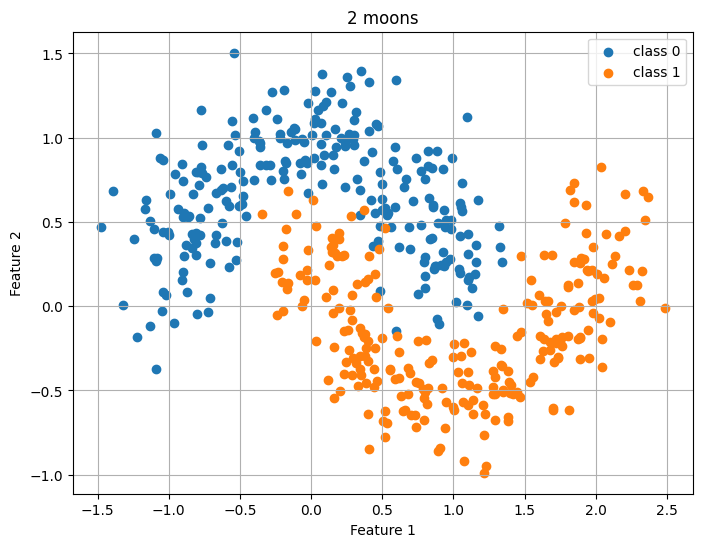

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label= 'class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label= 'class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2 moons")
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# Entraînement
from sklearn.metrics import accuracy_score
n_epochs = 200
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.view(-1), y_train)
    loss.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    logits = model(X_test)
    preds = (logits.squeeze() > 0).long()
    accuracy = accuracy_score(y_test, preds)

print(f"Précision du modèle classique : {accuracy:.2f}")

Précision du modèle classique : 0.88


In [178]:
def compute_hessian(model, criterion, X_train, y_train, last_layer=False, sigma0_squarred=1e-2):
    outputs = model(X_train)
    output_sig = torch.sigmoid(outputs)
    loss = (y_train*torch.log(output_sig)+ (1 - y_train)*torch.log(1-output_sig)).view(-1).sum()
    parameters = tuple(model.parameters())[-2:] if last_layer else tuple(model.parameters())
    grads = autograd.grad(loss, parameters, create_graph=True, retain_graph=True)
    grads_flat = torch.cat([grad_params.view(-1) for grad_params in grads])
    hessian = torch.zeros(grads_flat.shape[0], grads_flat.shape[0])                    
    for i in range(grads_flat.shape[0]):
        hessian_row = autograd.grad(grads_flat[i], parameters, retain_graph=True)
        hessian_row = torch.cat([hessian_row_params.view(-1) for hessian_row_params in hessian_row])
        hessian[i, :] = hessian_row
    return hessian + sigma0_squarred * torch.eye(hessian.shape[0])
compute_hessian(model, criterion, X_train, y_train, last_layer=True)

tensor([[-5.5367e+02, -4.3134e+01, -7.5547e+00,  ..., -2.5028e+02,
         -5.3563e+02, -3.2195e+03],
        [-4.3134e+01, -8.1863e+00, -4.4667e-01,  ..., -1.5245e+01,
         -3.2623e+01, -1.9692e+02],
        [-7.5547e+00, -4.4667e-01, -3.2763e-01,  ..., -1.0932e+01,
         -2.3401e+01, -8.0633e+01],
        ...,
        [-2.5028e+02, -1.5245e+01, -1.0932e+01,  ..., -3.5412e+02,
         -7.5804e+02, -2.6274e+03],
        [-5.3563e+02, -3.2623e+01, -2.3401e+01,  ..., -7.5804e+02,
         -1.6226e+03, -5.6237e+03],
        [-3.2195e+03, -1.9692e+02, -8.0633e+01,  ..., -2.6274e+03,
         -5.6237e+03, -2.5004e+04]])

In [179]:
def closed_form_confidence(model, criterion, X_train, y_train, X, last_layer=True, method='default'):
    model.zero_grad()

    outputs = model(X)
    hessian = compute_hessian(model, criterion, X_train, y_train, last_layer=last_layer)
    if method == 'diag':
        hessian = torch.diag(hessian) * torch.eye(hessian.shape[0])
    sigma = torch.inverse(-hessian)
    confidences = torch.zeros(X.shape[0])
    parameters = tuple(model.parameters())[-2:] if last_layer else tuple(model.parameters())
    
    for i in range(X.shape[0]):
        d = autograd.grad(outputs[i], parameters, retain_graph=True)
        d = torch.cat([grad_layer.view(-1) for grad_layer in d])
        z = outputs[i] / torch.sqrt(1 + (torch.pi / 8) * (d.T @ sigma @ d))
        confidences[i] = torch.sigmoid(z)
    return confidences
confidences = closed_form_confidence(model, criterion, X_train, y_train, X_test, last_layer=True, method='diag')
confidences

tensor([0.1430, 0.2960, 0.2008, 0.9385, 0.7390, 0.4281, 0.0273, 0.9248, 0.9662,
        0.0658, 0.0989, 0.9784, 0.9778, 0.0677, 0.8761, 0.9611, 0.0149, 0.9656,
        0.0179, 0.0984, 0.6877, 0.1724, 0.9794, 0.0802, 0.0822, 0.0557, 0.0400,
        0.0227, 0.8473, 0.9417, 0.5893, 0.2002, 0.0497, 0.0275, 0.9041, 0.4211,
        0.8789, 0.8870, 0.9822, 0.0418, 0.0593, 0.5656, 0.1070, 0.1520, 0.6722,
        0.5320, 0.1573, 0.1899, 0.9008, 0.1314, 0.4821, 0.9650, 0.8189, 0.9268,
        0.8179, 0.0193, 0.9372, 0.1558, 0.9811, 0.3774, 0.9535, 0.1818, 0.0688,
        0.5791, 0.2207, 0.5019, 0.0676, 0.9752, 0.0613, 0.7814, 0.0100, 0.9424,
        0.8707, 0.1078, 0.7568, 0.7214, 0.0607, 0.9469, 0.0520, 0.4209, 0.6768,
        0.0521, 0.0152, 0.6295, 0.9087, 0.0847, 0.9630, 0.0969, 0.8988, 0.0190,
        0.1242, 0.8939, 0.4360, 0.1884, 0.2103, 0.9393, 0.9618, 0.3734, 0.0634,
        0.6772, 0.7372, 0.0481, 0.9479, 0.9820, 0.4068, 0.9423, 0.1522, 0.0196,
        0.3607, 0.9425, 0.9547, 0.8754, 

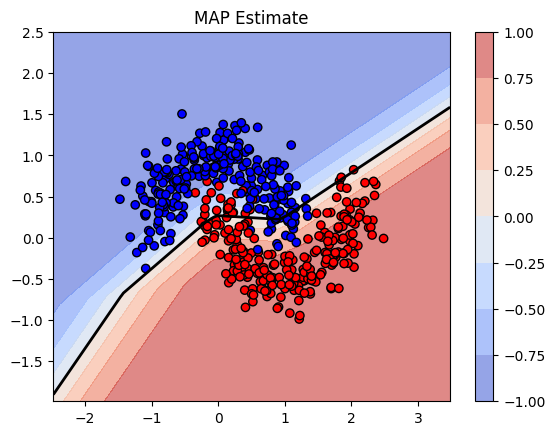

NameError: name 'temp_scaler' is not defined

In [180]:
def plot_decision_boundary(model, X, y, title, temp_scaler=None, hessian=None):
    # Grille pour la surface de décision
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    
    with torch.no_grad():
        logits = model(grid).squeeze()
        if temp_scaler is not None:
            logits = temp_scaler(logits)
        preds = torch.sigmoid(logits).reshape(xx.shape)

    # Confiance = |2p - 1|
    confidence = 2 * preds - 1

    plt.contourf(xx, yy, confidence, alpha=0.6, cmap='coolwarm')
    plt.colorbar()
    
    # Frontière de décision
    plt.contour(xx, yy, preds, levels=[0.5], colors='black', linewidths=2)
    
    # Points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')

    plt.title(title)
    plt.show()

# Affichage des résultats
plot_decision_boundary(model, X_train.numpy(), y_train.numpy(), "MAP Estimate")
plot_decision_boundary(model, X_train.numpy(), y_train.numpy(), "Temperature Scaling", temp_scaler=temp_scaler)
